**Author:** Prof. AJ Smit

Department of Biodiversity and Conservation Biology

University of the Western Cape

# Topic 13: Cluster analysis

"**There are two types of people in the world: 1) those who extrapolate from incomplete data.**" -- Anon.

We have seen that the WHO/SDG data seem to form neat groupings of countries within their respective parent locations. In this exercise we will apply a cluster analysis called 'Partitioning Around Medoids' to these data. Whereas ordination attempts to display the presence and influence of gradients, clustering tries to place our samples into a certain number of discrete units or clusters. 

Broadly speaking, clustering algorithms can be devided into ['hierarchical agglomerative classification'](https://www.davidzeleny.net/anadat-r/doku.php/en:hier-agglom_r) and [non-hierarchical classification (e.g. K-means)](https://www.davidzeleny.net/anadat-r/doku.php/en:non-hier_r). Numerical Ecology in R provides more information about the various kinds of classifications and make the following distinctions of classification methods: 'sequential or simultaneous,' 'agglomerative or divisive,' 'monothetic versus polythetic,' 'hierarchical versus non-hierarchical methods,' 'probabilistic versus non-probabilistic,' and 'fuzzy' methods. Regardless of how one classifies the classification alogrithms, they are well-represented in R. The workhorse cluster analysis package in R is, strangely, called **cluster**. The function we will use in this example is called `pam()` but several other functions are also available, most notably 'Agglomerative Nesting (Hierarchical Clustering)' called by `agnes()`, 'DIvisive ANAlysis Clustering' by `diana()`, and 'Fuzzy Analysis Clustering' by `fanny()`. The `kmeans()` and `hclust()` functions in base R are also available and frequently used by ecologists. Of course, there is also the old faithful [TWINSPAN](https://github.com/jarioksa/twinspan) which has been ported to R that might be of interest still. All of the cluster analyses functions come with their own plotting methods, and you should become familiar with them.

The package **factoextra** provides useful helper functions for cluster analysis, and also provides clustering functions that can be used *in lieu* of the ones mentioned above.

For examples of clustering, please refer to:

1. Numerical Ecology in R, pp. 53-62. Later pages in the Cluster chapter go deeper into clustering and you should read over it for a broad overview. For the purpose of this module, we will focus on 4.3 Hierarchical Clustering and 4.4 Agglomerative Clustering.
2. A [Kaggle challenge](https://www.kaggle.com/davimattar/help-international-clustering-using-r) with examples of both Hierarchical Clustering and K-means Clustering.
3. The `iris` dataset is an excellent dataset to practice cluster analysis on; in fact, cluster analysis examples of this dataset are common on the internet.

Let's explore the WHO/SDG dataset usig the `pam()` function.

## Set-up the analysis environment

In [1]:
library(tidyverse) 
library(cluster)
library(ggcorrplot)
library(factoextra)
library(vegan)

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

Loading required package: permute

Loading required package: lattice

This is vegan 2.5-7



## Load the SDG data

I load the combined dataset that already had their missing values imputed (as per the [PCA](https://github.com/ajsmit/Quantitative_Ecology/blob/main/jupyter_lab/Topic_8-PCA-SDG-example.ipynb) example).

In [2]:
SDGs <- read_csv("/Users/ajsmit/Dropbox/R/workshops/Quantitative_Ecology/exercises/WHO/SDG_complete.csv")
SDGs[1:5, 1:8]


── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  ParentLocation = col_character(),
  Location = col_character()
)
ℹ Use `spec()` for the full column specifications.




ParentLocation,Location,other_1,other_2,SDG1.a,SDG16.1,SDG3.1_1,SDG3.2_1
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Eastern Mediterranean,Afghanistan,61.65,15.59,2.14,9.02,673,134.802054
Europe,Albania,77.84,21.13,9.62,3.78,16,7.552973
Africa,Algeria,76.54,21.81,10.73,1.66,113,37.999310
Africa,Angola,61.72,16.71,5.43,9.82,246,124.853365
Americas,Antigua and Barbuda,76.14,20.43,11.61,2.42,43,5.940594


The parent locations:

In [3]:
unique(SDGs$ParentLocation)
length(unique(SDGs$ParentLocation))

[1] "Eastern Mediterranean" "Europe"                "Africa"               
[4] "Americas"              "Western Pacific"       "South-East Asia"

[1] 6

The number of countries:

In [4]:
length(SDGs$Location)

[1] 176

As is often the case with measured variables, we can start our exploration with a correlation analysis to see the extent to which correlation between variable pairs is present:

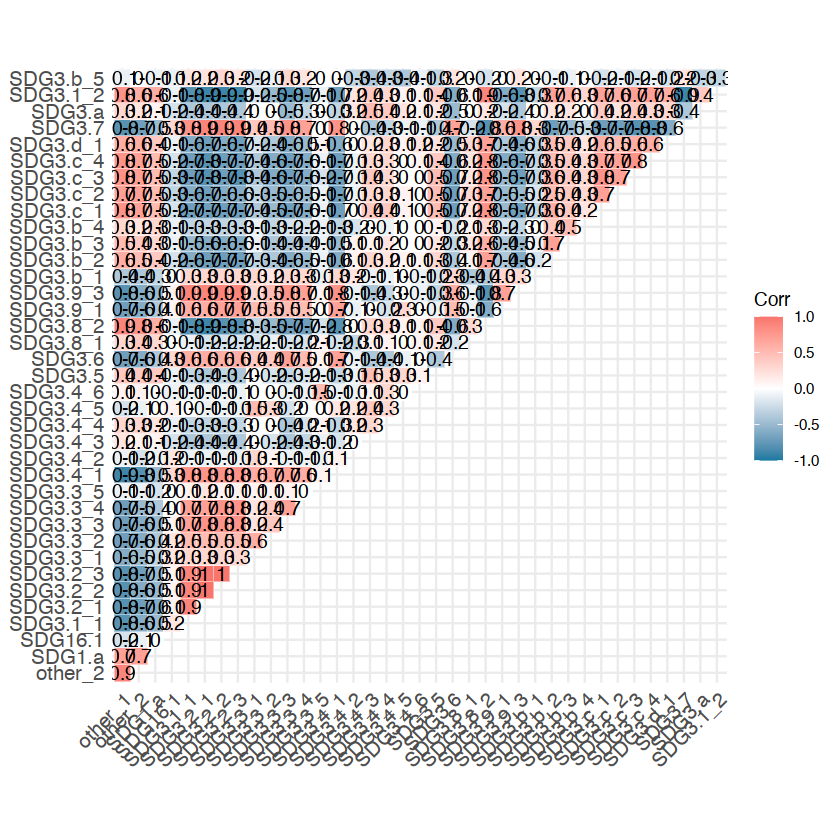

In [5]:
# a correalation matrix
corr <- round(cor(SDGs[3:ncol(SDGs)]), 1)
ggcorrplot(corr, type = 'upper', outline.col = "white",
          colors = c("#1679a1", "white", "#f8766d"),
          lab = TRUE)

We might decide to remove collinear variables, but I proceed with the full dataset. We need to standardise first to account for the different measurement scales of the variables. We can calculate Euclidian distances before running `pam()`, but it can also be specified within the function call. We do the latter:

In [6]:
SDGs_std <- decostand(SDGs[3:ncol(SDGs)], method = "standardize")
# SDGs_euc <- vegdist(SDGs_std, method = "euclidian")
rownames(SDGs_std) <- SDGs$Location # carry location names into output

The frustrating thing with cluster analysis, which often confuses novice users, is that there is often an expectation that the clustering alorithm decides for the user how many clusters to use. However, this is a misconception that must be overcome. Although some numerical guidance can be obtained through 'silhouette,' 'within cluster sum of squares' or 'elbow' analysis, and 'gap statistic', in my experience they are no substitute for the power of human reasoning. Let us see what the **factoextra** package function `fviz_nbclust()` tell us about how many group to use:

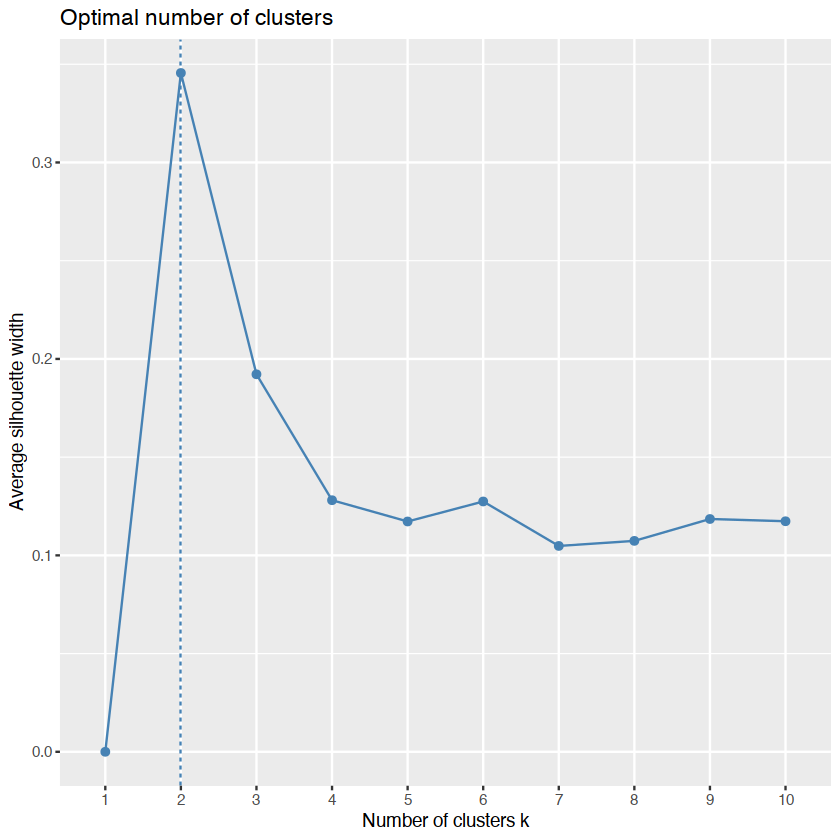

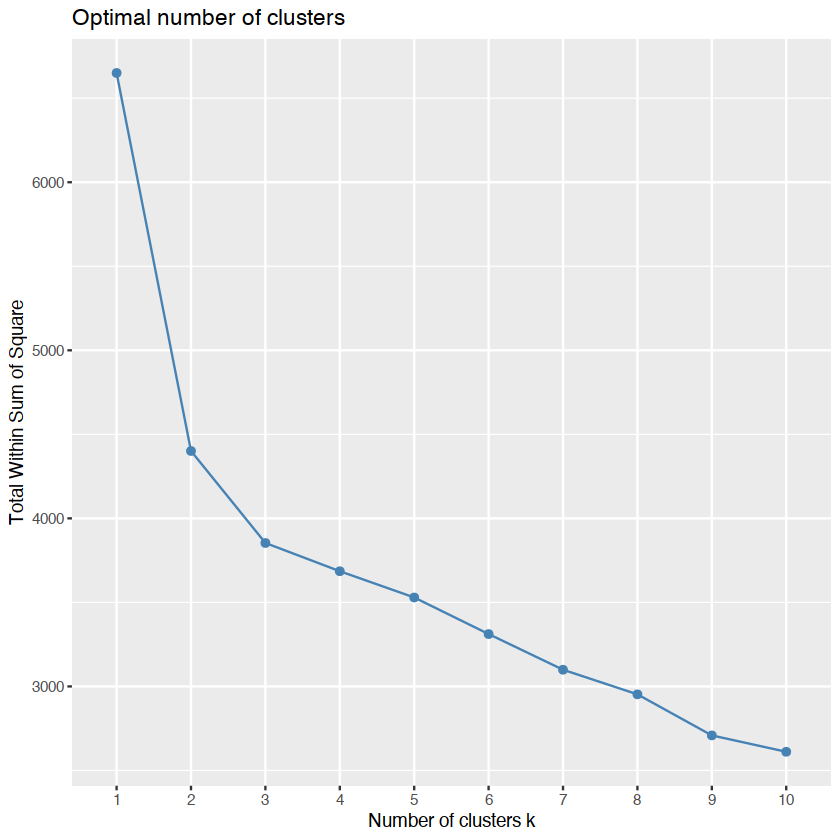

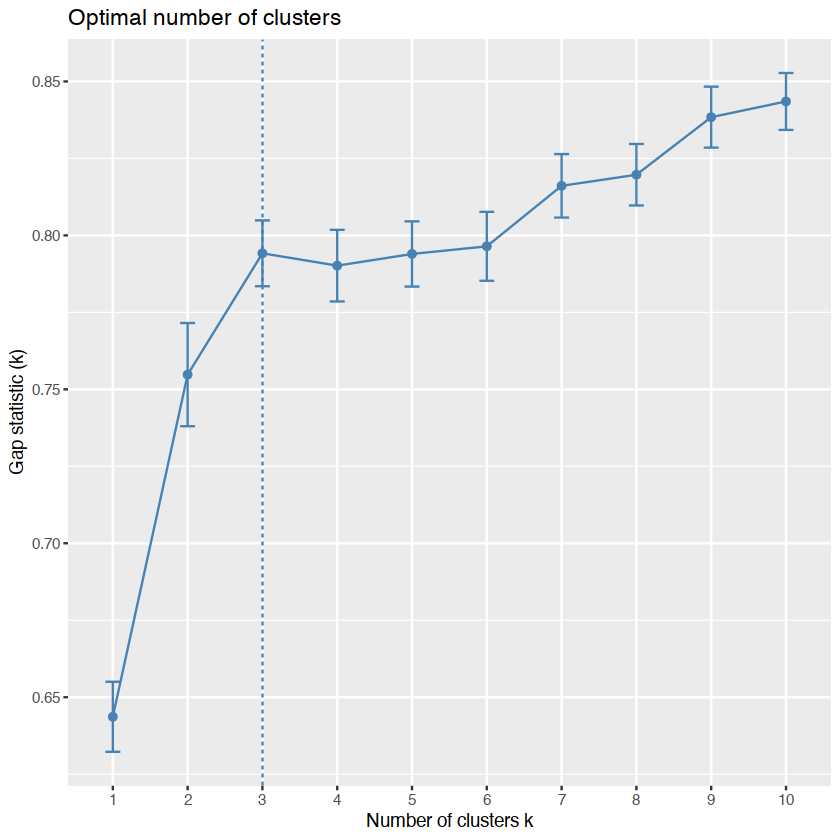

In [7]:
# using silhouette analysis
fviz_nbclust(SDGs_std, cluster::pam, method = "silhouette") + theme_grey()

# total within cluster sum of square / elbow analysis
fviz_nbclust(SDGs_std, cluster::pam, method = "wss") + theme_grey()

# gap statistics
fviz_nbclust(SDGs_std, cluster::pam, method = "gap_stat") + theme_grey()

Even with the supposedly objective assessment of what the optimal number of clusters should be, we see that each method still provides a different result. Much better to proceed with expert knowledge about the nature of the data and the intent of the study. Let us proceed with three clusters as I think two clusters are insufficient for our purpose.

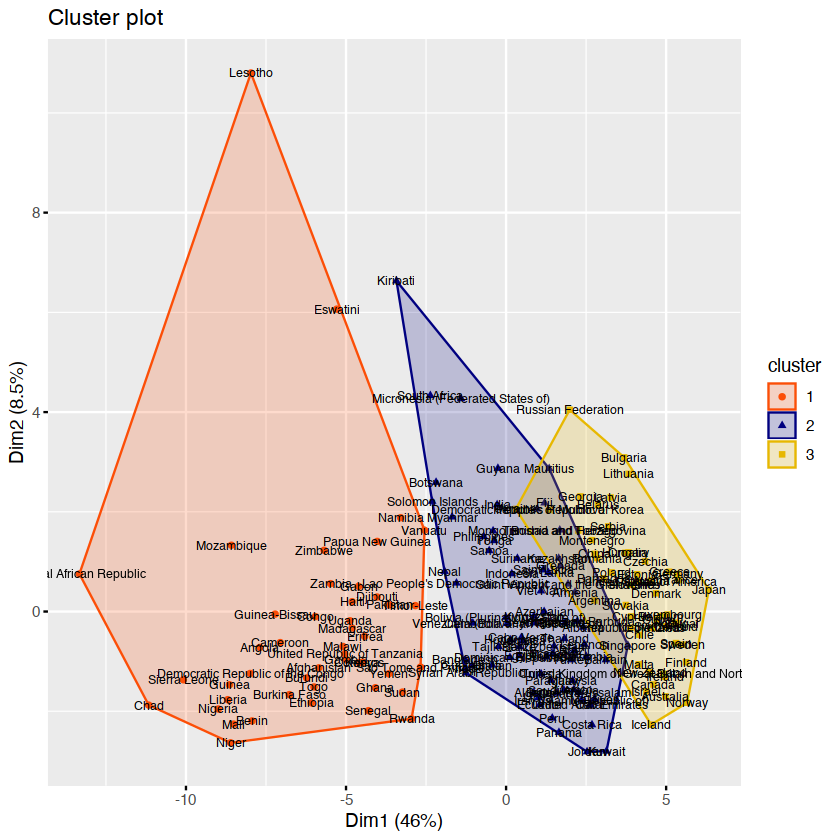

In [8]:
SDGs_pam <- pam(SDGs_std, metric = "euclidean", k = 3)

fviz_cluster(SDGs_pam, geom = "point", ellipse.type = "convex", palette = c("#FC4E07", "navy", "#E7B800")) +
  geom_text(aes(label = SDGs$Location), size = 2.5)

We cannot clearly see where SA is, so let's create a clearer plot:

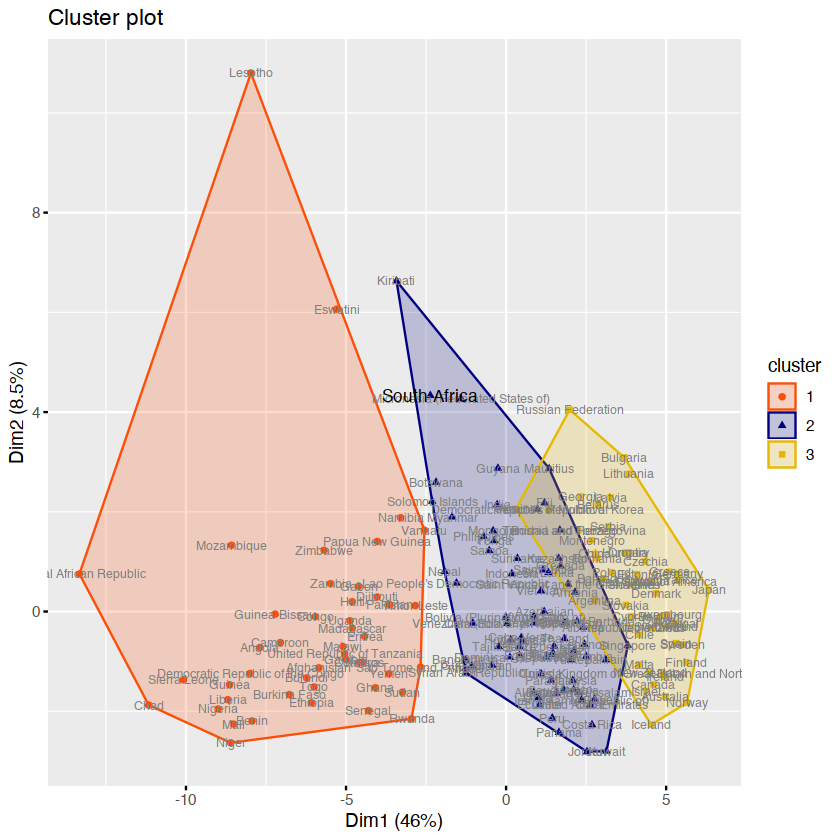

In [9]:
# scale SA bigger for plotting
SDGs <- SDGs |> 
  mutate(col_vec = ifelse(Location == "South Africa", "black", "grey50"),
         scale_vec = ifelse(Location == "South Africa", 3.5, 2.5))

fviz_cluster(SDGs_pam, geom = "point", ellipse.type = "convex", palette = c("#FC4E07", "navy", "#E7B800")) +
  geom_text(aes(label = SDGs$Location), size = SDGs$scale_vec, col = SDGs$col_vec)

Note that `pam()`, unlike hierarchical or agglomerative clustering, does not produce a typical dendrogram and the usual way to graphically present the cluster arrangement is to create a scatter plot similar to an ordination diagramme (but it is NOT an ordination diagram).

Same as above, but showing a star plot and numbers indicating the countries (their row numbers in `SDGs`):

Warning message:
“ggrepel: 131 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


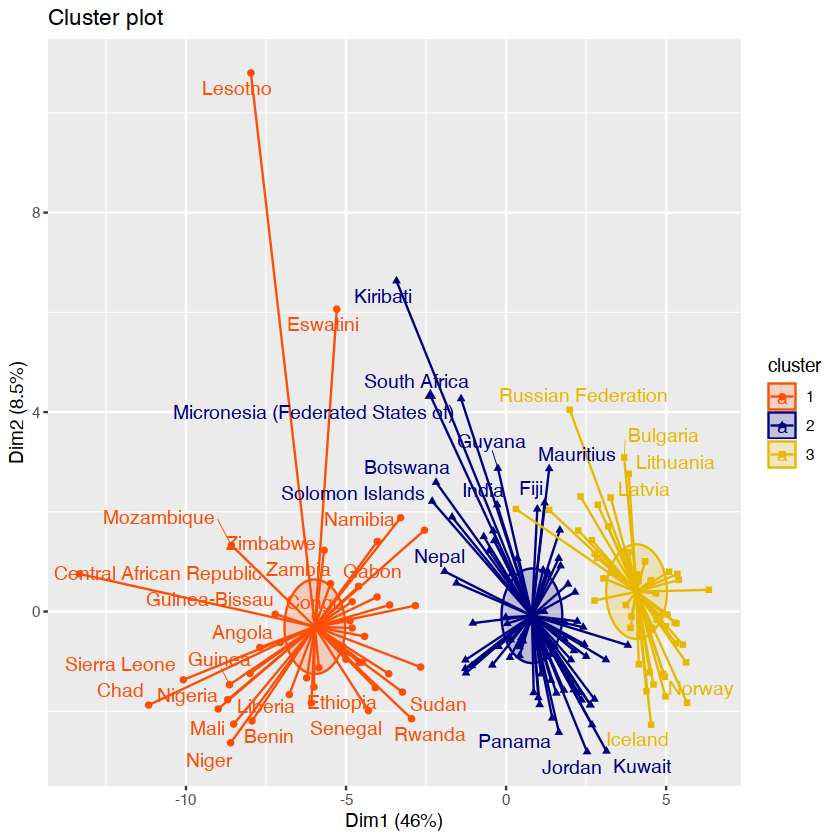

In [10]:
fviz_cluster(SDGs_pam, palette = c("#FC4E07", "navy", "#E7B800"), ellipse.type = "euclid", 
             star.plot = TRUE, repel = TRUE, pointsize = SDGs$scale_vec * 0.6) + # SA, no 147, plotted slightly bigger
  theme_grey()

Do a silhouette analysis to check cluster fidelity:

  cluster size ave.sil.width
1       1   46          0.27
2       2   78          0.09
3       3   52          0.27


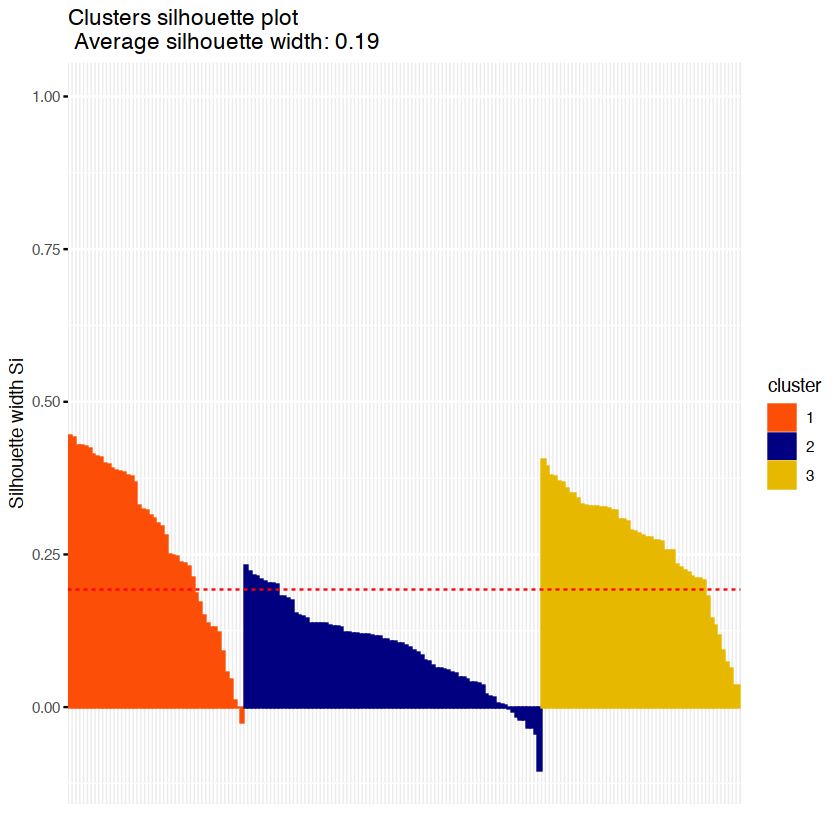

In [11]:
fviz_silhouette(SDGs_pam, palette = c("#FC4E07", "navy", "#E7B800"), ggtheme = theme_grey())

Once happy with the number of clusters, find the median value for each cluster:

In [12]:
SDGs_centroids <- SDGs |> 
  mutate(cluster = SDGs_pam$clustering) |> 
  group_by(cluster) |> 
  summarise_at(vars(other_1:SDG3.b_5), median, na.rm = TRUE)
SDGs_centroids

cluster,other_1,other_2,SDG1.a,SDG16.1,SDG3.1_1,SDG3.2_1,SDG3.2_2,SDG3.2_3,SDG3.3_1,⋯,SDG3.b_4,SDG3.c_1,SDG3.c_2,SDG3.c_3,SDG3.c_4,SDG3.d_1,SDG3.7,SDG3.a,SDG3.1_2,SDG3.b_5
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,62.45,16.690,5.430,8.875,396,90.039861,214.289263,151.64193,0.665,⋯,77.97417,1.27000,7.13000,0.1033939,0.3408167,62.31386,90.75825,13.85000,69.56417,67.01951
2,73.18,19.600,9.645,4.400,60,19.849407,33.889190,28.09832,0.135,⋯,85.61572,20.15064,33.62949,3.7512538,5.1544319,79.00000,42.72939,21.66605,92.60967,59.37249
3,80.40,23.245,13.255,1.285,7,2.776335,4.733092,4.00128,0.055,⋯,88.38658,35.35159,70.20500,6.4080851,7.5359459,87.80533,10.40000,26.70000,99.75000,48.98867


`pam()` can also provide the most representative example countries of each cluster. Note that the values inside are very different from that produced when we calculated the medians because `medoids` report the standardised data:

In [13]:
SDGs_pam$medoids

,other_1,other_2,SDG1.a,SDG16.1,SDG3.1_1,SDG3.2_1,SDG3.2_2,SDG3.2_3,SDG3.3_1,SDG3.3_2,⋯,SDG3.b_4,SDG3.c_1,SDG3.c_2,SDG3.c_3,SDG3.c_4,SDG3.d_1,SDG3.7,SDG3.a,SDG3.1_2,SDG3.b_5
Togo,-1.3082283,-1.04437853,-1.1903643,0.06808945,1.1324894,1.3017843,1.4102734,1.3592849,0.1576964,-0.4579343,⋯,-0.02793898,-1.1831072,-0.9983214,-1.1842216,-1.0940540,-1.0278904,0.8082986,-1.53587553,-1.3841046,0.7500056
Nicaragua,0.3737688,0.08872107,1.3796506,0.08533933,-0.2323864,-0.2586716,-0.3767895,-0.3446689,-0.3154270,-0.4579343,⋯,0.94197637,-0.6102974,-0.6958462,0.3067516,0.3246320,0.7660773,-0.2790219,-0.05503528,0.5008573,0.1814304
Czechia,0.8823411,0.61551298,0.8833042,-0.64737012,-0.6765494,-0.8435034,-0.7133630,-0.7745694,-0.1376945,-0.7136379,⋯,0.25560867,1.1612648,0.7385150,1.2426058,0.5534738,0.7415003,-0.9713149,1.07144665,0.9941603,-0.5157917


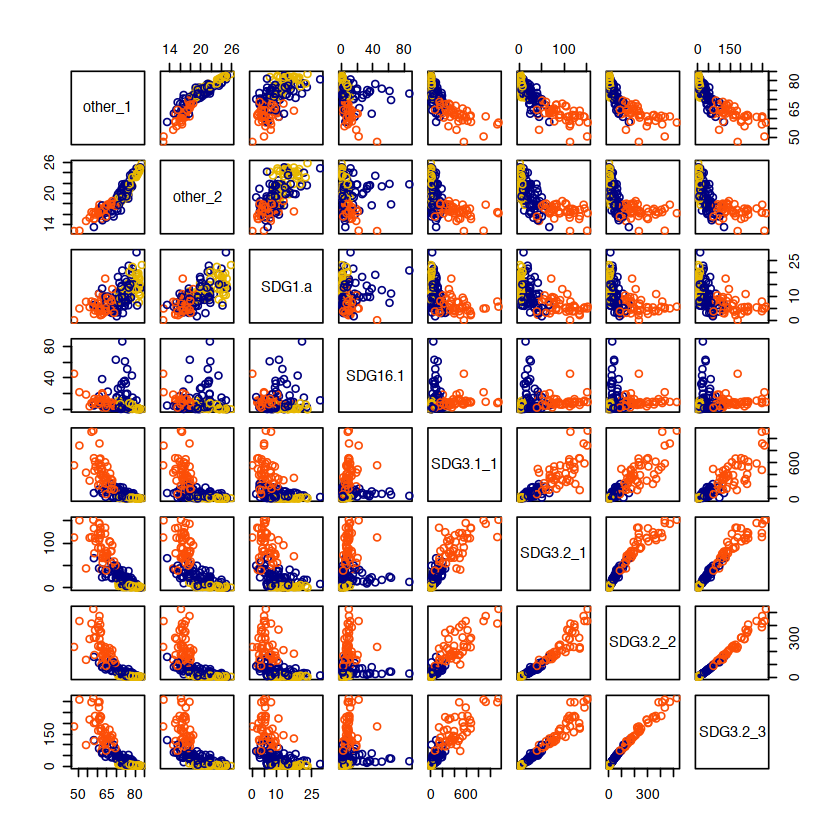

In [14]:
pairs(SDGs[, 3:10], col = c("#FC4E07", "navy", "#E7B800")[SDGs_pam$clustering])

### Questions

This is the fnal set of questions for Quantitative Ecology.

1. What happens if we use `pam()` to create four, five, or even six clusters?
2. In your reasoned opinion, what would be the optimal number of clusters to use?
3. Repeat the analysis using either `kmeans()` or `hclust()`, and feel free to use the **factoextra** helper functions and visualisations. Are the results markedly different? Which clustering approach do you wish to proceed with---i.e., `pam()`, `hclust()` or `kmeans()`?
4. Build upon the narrative that you have already developed in the [previous assignment](https://github.com/ajsmit/Quantitative_Ecology/blob/main/jupyter_lab/Topic_8-PCA-SDG-example.ipynb) and describe the patterns that you observe at the end of your final cluster selection (i.e. based on the optimal number of clusters and whichever cluster technique you deem most appropriate), and explain these patterns in terms of the global socio-political/socio-economic landscape.
5. Regardless of how many clusters you choose, South Africa often seems to teeter at the edge between the group of African countries and some other parent location. Why?

<span style="color:red">You are welcome to submit the entire asignment (the [previous assignment](https://github.com/ajsmit/Quantitative_Ecology/blob/main/jupyter_lab/Topic_8-PCA-SDG-example.ipynb) and this one) in an R script wherein you provide answers to these questions by no later than 17:00 on Monday 2 August 2021.</span>